# Import Modules & Define Functions

## Modules

In [1]:
# General modules & loading data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display
from tqdm import trange

# Splitting & Oversampling Modules
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter

# Pipeline Building Modules
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Model Modules
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

# Performance Metrics Modules
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, matthews_corrcoef, fbeta_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve


## Define Functions

### Train/Test Split

In [2]:
def train_test_split(image_dataframe,n_splits=2, encode_targets = True, apply_SMOTE = True, random_state = 42):
    skf = StratifiedKFold(n_splits)
    
    ifeatures = image_dataframe.iloc[:, 1:-1]
    feature_names = ifeatures.columns
    ifeatures = ifeatures.to_numpy()
    itargets = image_dataframe.iloc[:, -1].to_numpy()

    for train_index, test_index in skf.split(ifeatures, itargets):
        train_feats, test_feats = ifeatures[train_index], ifeatures[test_index]
        train_targets, test_targets = itargets[train_index], itargets[test_index]
    
    if encode_targets:
        le = preprocessing.LabelEncoder()
        le.fit(train_targets)
        le.classes_ = le.classes_[::-1]
        train_targets_encoded=le.transform(train_targets)
        test_targets_encoded=le.transform(test_targets)
     
    if apply_SMOTE:
        oversample = SMOTE(k_neighbors=4, random_state=random_state)
        train_feats, train_targets_encoded = oversample.fit_resample(train_feats, train_targets_encoded)
        train_targets = le.inverse_transform(train_targets_encoded) 

    packaged_result = {'feature_names': feature_names,
                       'pre_split_feature_values': ifeatures,
                       'pre_split_targets': itargets,
                       'train_feats': train_feats,
                       'test_feats': test_feats,
                       'train_targets': train_targets,
                       'test_targets': test_targets,
                       'train_targets_encoded': train_targets_encoded,
                       'test_targets_encoded': test_targets_encoded    
                        }
   
    return  packaged_result

### Single Timepoint Classifier Pipeline

In [3]:
def apply_single_clf(clf, split_data, timepoint, apply_feature_selection = False, bagging=False, random_seed =42, silent=False, save=''):
    
    split_data_timepoint = split_data[timepoint]
    
    feature_names = split_data_timepoint['feature_names'].values.tolist()
    train_feats = split_data_timepoint['train_feats']
    test_feats = split_data_timepoint['test_feats']
    train_targets= split_data_timepoint['train_targets_encoded']
    test_targets = split_data_timepoint['test_targets_encoded']

    
    clf_name = type(clf).__name__
    
    if bagging:
        clf_name = clf_name + ' + Bagging'
        clf = BaggingClassifier(base_estimator=clf, n_estimators=20, n_jobs=20, random_state=random_seed)

    elif apply_feature_selection:
        clf_name = clf_name + ' + Feature Selection'
        clf = Pipeline([('feature_selection', SelectFromModel(DecisionTreeClassifier(criterion='entropy', random_state=random_seed))),
                        ('classification', clf)
                        ])
        
    
    if type(clf).__name__ =='XGBClassifier':

        clf_fit =  clf.fit(train_feats, train_targets, eval_metric='aucpr')
        
        
    else:
        clf_fit =  clf.fit(train_feats, train_targets)
    
    
    
    train_y_pred = clf_fit.predict(train_feats)
    train_y_probas = clf_fit.predict_proba(train_feats)
    train_accuracy = clf_fit.score(train_feats,train_targets)
    train_auc = roc_auc_score(train_targets, train_y_probas[:,1])
    
    train_results = {'accuracy': train_accuracy,
                    'AUC': train_auc,
                    'bi_class_probas': train_y_probas,
                    'predictions': train_y_pred
                    }
       
    test_y_pred = clf_fit.predict(test_feats)
    test_y_probas = clf_fit.predict_proba(test_feats)
    test_accuracy = clf_fit.score(test_feats,test_targets)
    test_auc = roc_auc_score(test_targets, test_y_probas[:,1])
    test_pr_score = average_precision_score(test_targets, test_y_probas[:,1])
    test_f1_score = f1_score(test_targets, test_y_pred)
    test_mcc = matthews_corrcoef(test_targets, test_y_pred)
    test_fb_score = fbeta_score(test_targets, test_y_pred, beta=2)
    
    res = {'model': clf_name,
           'timepoint': timepoint,
           'accuracy': test_accuracy,
           'AUC': test_auc,
           'pr_score': test_pr_score,
           'f1_score': test_f1_score,
           'fb_score': test_fb_score,
           'MCC_Score': test_mcc,
             }   
    results = pd.DataFrame(res,index=[0])
    
    test_results = {'accuracy': test_accuracy,
                    'AUC': test_auc,
                    'pr_score': test_pr_score,
                    'f1_score': test_f1_score,
                    'fb_score': test_fb_score,
                    'MCC_Score': test_mcc,
                    'bi_class_probas': test_y_probas,
                    'predictions': test_y_pred,
                    'results_df': results
                    } 
    
    packaged_result = {'train_result': train_results,
                       'test_result': test_results,
                       'timepoint': timepoint
                       }
    
    
    
    if apply_feature_selection:
        selected_features = [split_data_timepoint['feature_names'][i] for i in clf_fit['feature_selection'].get_support(indices=True)]
        packaged_result['selected_features']=selected_features

    if not silent:
        print(f'Classifier: {clf_name}')
        print(f'Feature Selection Applied = {apply_feature_selection}')
        if apply_feature_selection:
            print(f'Features Selected:{selected_features}')
        print(f"Number of mislabeled points out of a total {len(test_feats)} points : {(test_targets != test_y_pred).sum()}")

        display(results)
  
        # print(f'Train Accuracy: {train_accuracy}\nTrain AUC: {train_auc}\nTrain AUC: {train_auc}')
        # print(f'Test Accuracy: {test_accuracy}\nTest AUC: {test_auc}\nTest Average Precision: {test_pr_score}\nTest F1 Score: {test_f1_score}\nTest MCC Score: {test_mcc}')
        plt.style.use('classic')
        fig, axs = plt.subplots(1,3, figsize = (22.5,5))
        
        cm = plot_confusion_matrix(clf, test_feats,test_targets, ax=axs[0])
        roc = plot_roc_curve(clf, test_feats,test_targets, ax=axs[1] )
        pr = plot_precision_recall_curve(clf, test_feats,test_targets, ax=axs[2])
        
        fig.suptitle(clf_name+' '+timepoint)
        packaged_result['confusion_matrix']=cm
        packaged_result['roc']=roc
        if not save=='':
            plt.savefig(save+clf_name+' '+timepoint+'.png')
        plt.close(fig)
    if type(clf).__name__ =='XGBClassifier':    
        clf_fit.get_booster().feature_names = feature_names
        
    packaged_result['fit_model'] = clf_fit
    
    
    return packaged_result

### Multi Timepoint Classifier Pipeline

In [4]:
def apply_multi_clf(clf, split_data, apply_feature_selection = False, bagging=False, random_seed =42, silent=False):
    timepoints = list(split_data.keys())
    clf_name = type(clf).__name__
    
    # test_feats = split_data[timepoints[0]]['test_feats']
    train_targets= split_data[timepoints[0]]['train_targets_encoded']
    test_targets = split_data[timepoints[0]]['test_targets_encoded']

    layer1_outputs = {}
    for t in timepoints:
        layer1_outputs[t] = apply_single_clf(clf,split_data,timepoint = t, silent=True, bagging=bagging)
    
    layer1_train_features = np.concatenate((layer1_outputs['t1']['train_result']['bi_class_probas'],layer1_outputs['t2']['train_result']['bi_class_probas']),axis=1)
    layer1_test_features  = np.concatenate((layer1_outputs['t1']['test_result']['bi_class_probas'],layer1_outputs['t2']['test_result']['bi_class_probas']),axis=1)

    layer2_fit =  clf.fit(layer1_train_features, train_targets)
    
    layer2_y_pred = layer2_fit.predict(layer1_test_features)
    layer2_y_probas = layer2_fit.predict_proba(layer1_test_features)
    layer2_accuracy = layer2_fit.score(layer1_test_features,test_targets)
    layer2_auc = roc_auc_score(test_targets, layer2_y_probas[:,1])
    layer2_pr_score = average_precision_score(test_targets, layer2_y_probas[:,1])
    layer2_f1_score = f1_score(test_targets, layer2_y_pred)
    layer2_fb_score = fbeta_score(test_targets, layer2_y_pred,beta=2)
    layer2_mcc = matthews_corrcoef(test_targets, layer2_y_pred)
    
    
    res = {'model': clf_name,
           'accuracy': layer2_accuracy,
           'AUC': layer2_auc,
           'PR_score': layer2_pr_score,
           'f1_score': layer2_f1_score,
           'fb_score': layer2_fb_score,
           'MCC_Score': layer2_mcc,
          }
    
    results = pd.DataFrame(res,index=[0])
    
    if not silent:
        fig, axs = plt.subplots(1,3, figsize = (22.5,5))
        cm = plot_confusion_matrix(clf, layer1_test_features,test_targets,ax=axs[0])
        roc = plot_roc_curve(clf, layer1_test_features,test_targets, ax=axs[1] )
        pr = plot_precision_recall_curve(clf, layer1_test_features,test_targets, ax=axs[2])
        fig.suptitle(clf_name)
        # print(f'Test Accuracy: {layer2_accuracy}\nTest AUC: {layer2_auc}\nTest Average Precision: {layer2_pr_score}\nTest f1 Score: {layer2_f1_score}\nTest MCC Score: {layer2_mcc}')
        # plt.close(fig)
        print(results)
        print('\n')
    
    packaged_result = {'fit_model': layer2_fit,
                    'accuracy': layer2_accuracy,
                    'AUC': layer2_auc,
                    'PR_score': layer2_pr_score,
                    'f1_score': layer2_f1_score,
                    'fb_score': layer2_fb_score,
                    'MCC_Score': layer2_mcc,
                    'bi_class_probas': layer2_y_probas,
                    'predictions': layer2_y_pred,
                    'results_df': results
                    }
    # return layer1_features
    return packaged_result

# Loading Data & Applying Split

Load Data & Perform Random Split

In [5]:
root = os.path.split(os.getcwd())[0]
save_path = root+'\\0.2 outputs\\Models\\'
image_feats = {'t1': pd.read_csv(root + '\\0.2 outputs\Wavelet\T1\Merged_Features_T1.csv'),'t2': pd.read_csv(root + '\\0.2 outputs\Wavelet\T2\Merged_Features_T2.csv')}
timepoints = ['t1','t2']
rnd_state = 2
split_data = {'t1':train_test_split(image_feats['t1'], random_state=rnd_state), 't2':train_test_split(image_feats['t2'], random_state=rnd_state)}

# Single Timepoint Models

### Apply Naive Bayes

Basic Naive Bayes

In [6]:
clf = GaussianNB()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=False, save=save_path)

Classifier: GaussianNB
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB,t1,0.916667,0.871094,0.615132,0.666667,0.714286,0.624758


Classifier: GaussianNB
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 20


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB,t2,0.444444,0.382812,0.122222,0.166667,0.277778,-0.039528


Naive Bayes preceeded by Decision Tree feature selector

In [7]:
clf = GaussianNB()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=True, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=True, bagging=False, save=save_path)

Classifier: GaussianNB + Feature Selection
Feature Selection Applied = True
Features Selected:['PET_wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis', 'PET_wavelet-HLH_glszm_SmallAreaHighGrayLevelEmphasis', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 11


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Feature Selection,t1,0.694444,0.585938,0.190278,0.153846,0.2,0.0


Classifier: GaussianNB + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis', 'PET_wavelet-HLH_glcm_ClusterTendency']
Number of mislabeled points out of a total 36 points : 14


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Feature Selection,t2,0.611111,0.304688,0.158889,0.125,0.178571,-0.0625


Naive Bayes applied with Bagging

In [8]:
clf = GaussianNB()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=True, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=True, save=save_path)

Classifier: GaussianNB + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Bagging,t1,0.916667,0.863281,0.6125,0.666667,0.714286,0.624758


Classifier: GaussianNB + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 18


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GaussianNB + Bagging,t2,0.5,0.476562,0.130159,0.181818,0.294118,0.0


### Apply AdaBoostClassifier

Base AdaBoostClassifier

In [9]:
clf = AdaBoostClassifier()

t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=False, save=save_path)

Classifier: AdaBoostClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 5


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier,t1,0.861111,0.847656,0.530556,0.444444,0.47619,0.369175


Classifier: AdaBoostClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier,t2,0.916667,0.757812,0.593478,0.571429,0.526316,0.533002


AdaBoostClassifier preceeded by Decision Tree feature selector

In [10]:
clf = AdaBoostClassifier()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=True, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=True, bagging=False, save=save_path)

Classifier: AdaBoostClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['PET_wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis', 'PET_wavelet-HLH_glszm_SmallAreaHighGrayLevelEmphasis', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Feature Selection,t1,0.833333,0.859375,0.317262,0.571429,0.769231,0.570088


Classifier: AdaBoostClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis', 'PET_wavelet-HLH_glcm_ClusterTendency']
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Feature Selection,t2,0.833333,0.453125,0.141865,0.25,0.25,0.15625


AdaBoostClassifier with bagging

In [11]:
clf = AdaBoostClassifier()

t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=True, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=True, save=save_path)


Classifier: AdaBoostClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 2


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Bagging,t1,0.944444,0.914062,0.726923,0.666667,0.555556,0.685994


Classifier: AdaBoostClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 3


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,AdaBoostClassifier + Bagging,t2,0.916667,0.789062,0.605311,0.571429,0.526316,0.533002


### GradientBoosting

GradientBoosting base model

In [12]:
clf = GradientBoostingClassifier()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=False, save=save_path)

Classifier: GradientBoostingClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier,t1,0.833333,0.914062,0.433333,0.571429,0.769231,0.570088


Classifier: GradientBoostingClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier,t2,0.833333,0.6875,0.305556,0.4,0.454545,0.316228


GradientBoosting preceeded by Decision Tree feature selector

In [13]:
clf = GradientBoostingClassifier()
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=True, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=True, bagging=False, save=save_path)

Classifier: GradientBoostingClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['PET_wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis', 'PET_wavelet-HLH_glszm_SmallAreaHighGrayLevelEmphasis', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Feature Selection,t1,0.833333,0.90625,0.4,0.571429,0.769231,0.570088


Classifier: GradientBoostingClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis', 'PET_wavelet-HLH_glcm_ClusterTendency']
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Feature Selection,t2,0.833333,0.578125,0.145833,0.25,0.25,0.15625


GradientBoosting with bagging

In [14]:
clf = GradientBoostingClassifier(n_estimators=50)
t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=True, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=True, save=save_path)

Classifier: GradientBoostingClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 1


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Bagging,t1,0.972222,0.945312,0.840909,0.857143,0.789474,0.852803


Classifier: GradientBoostingClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,GradientBoostingClassifier + Bagging,t2,0.833333,0.726562,0.310833,0.4,0.454545,0.316228


Classifier: XGBClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier,t1,0.833333,0.765625,0.262626,0.4,0.454545,0.316228


Classifier: XGBClassifier
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 8


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier,t2,0.777778,0.675781,0.280556,0.333333,0.416667,0.236228


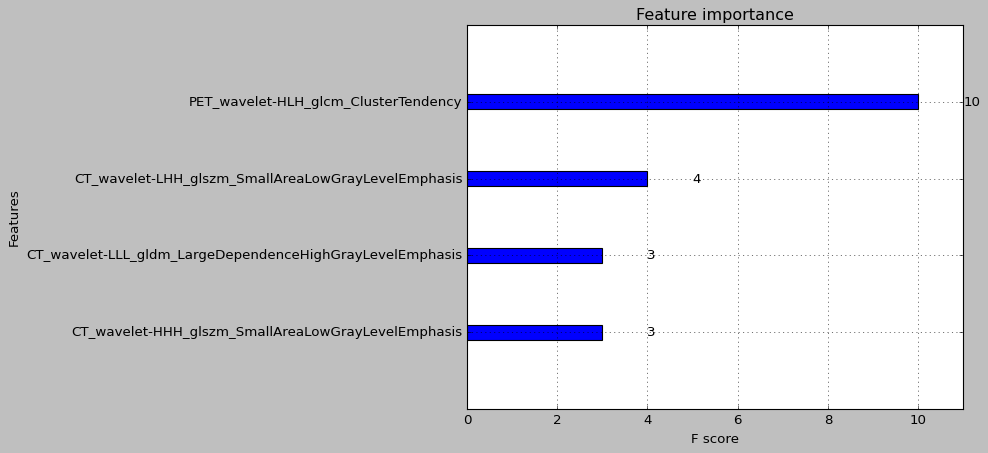

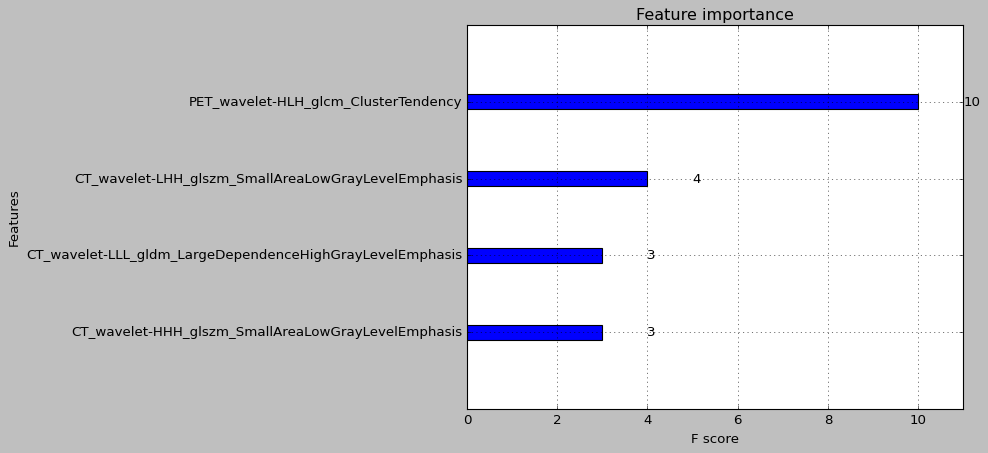

In [15]:
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators= 10, learning_rate=0.01,use_label_encoder=False, max_depth=10, n_jobs=18)

t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=False, save=save_path)
ft = xgb.plot_importance(t1_gnb['fit_model'])
ft = xgb.plot_importance(t2_gnb['fit_model'])

In [16]:
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators= 10, learning_rate=0.01,use_label_encoder=False, max_depth=10, n_jobs=18)

t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=True, bagging=False, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=True, bagging=False, save=save_path)

[11:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XGBClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['PET_wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis', 'PET_wavelet-HLH_glszm_SmallAreaHighGrayLevelEmphasis', 'PET_wavelet-HHH_firstorder_Skewness']
Number of mislabeled points out of a total 36 points : 7


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Feature Selection,t1,0.805556,0.773438,0.277778,0.461538,0.6,0.408248


[11:47:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XGBClassifier + Feature Selection
Feature Selection Applied = True
Features Selected:['CT_wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis', 'PET_wavelet-HLH_glcm_ClusterTendency']
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Feature Selection,t2,0.833333,0.65625,0.180556,0.25,0.25,0.15625


In [17]:
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators= 10, learning_rate=0.01,use_label_encoder=False, max_depth=10, n_jobs=18)

t1_gnb = apply_single_clf(clf, split_data, timepoint='t1', apply_feature_selection=False, bagging=True, save=save_path)
t2_gnb = apply_single_clf(clf, split_data, timepoint='t2', apply_feature_selection=False, bagging=True, save=save_path)
# ft = xgb.plot_importance(t1_gnb['fit_model'])
# ft = xgb.plot_importance(t2_gnb['fit_model'])

Classifier: XGBClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 2


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Bagging,t1,0.944444,0.898438,0.684066,0.666667,0.555556,0.685994


Classifier: XGBClassifier + Bagging
Feature Selection Applied = False
Number of mislabeled points out of a total 36 points : 6


,model,timepoint,accuracy,AUC,pr_score,f1_score,fb_score,MCC_Score
0,XGBClassifier + Bagging,t2,0.833333,0.757812,0.528704,0.4,0.454545,0.316228


# Multi-timepoint Models

        model  accuracy       AUC  PR_score  f1_score  fb_score  MCC_Score
0  GaussianNB  0.555556  0.597656  0.347222       0.2    0.3125   0.039528




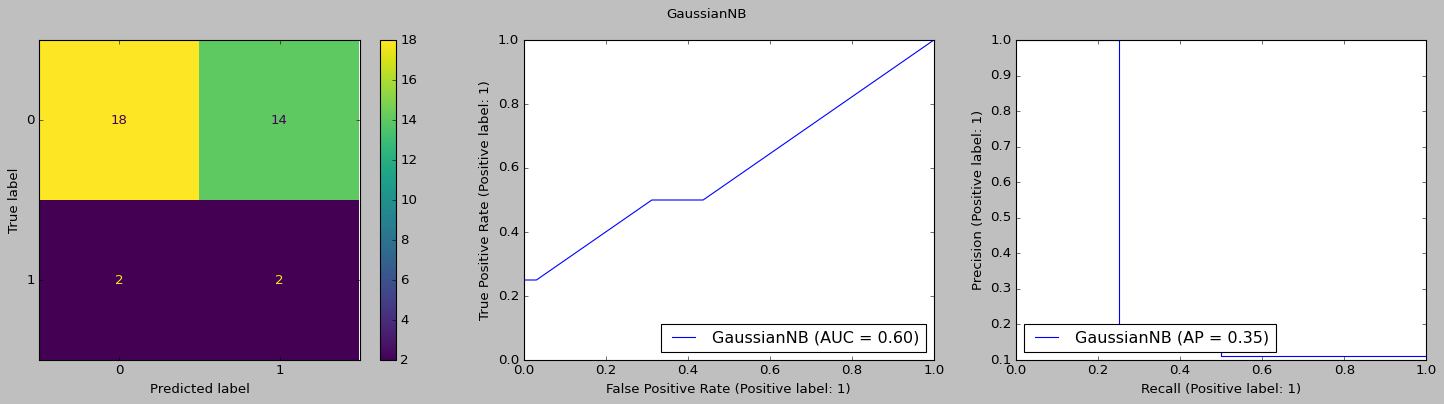

In [18]:
clf = GaussianNB()
nb_res =apply_multi_clf(clf, split_data)
# test

In [19]:
clf = AdaBoostClassifier()

ada_res=[]
for i in trange(100):
    ada_res.append(apply_multi_clf(clf, split_data,silent=True))

100%|██████████| 100/100 [01:25<00:00,  1.18it/s]


In [20]:
clf = GradientBoostingClassifier()
gbc_res=[]
for i in trange(100):
    gbc_res.append(apply_multi_clf(clf, split_data,silent=True))

100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


In [25]:
clf = xgb.XGBClassifier(objective='binary:logistic',eval_metric = 'logloss', n_estimators= 10, learning_rate=0.01,use_label_encoder=False, max_depth=10, n_jobs=18)

xgb_res=[]
for i in trange(100):
    xgb_res.append(apply_multi_clf(clf, split_data,silent=True))

100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


In [22]:
ada_res
average_accuracy = sum([ada_res[i]['accuracy'] for i in range(100)])/100
average_AUC = sum([ada_res[i]['AUC'] for i in range(100)])/100
average_pr_score = sum([ada_res[i]['PR_score'] for i in range(100)])/100
average_f1 = sum([ada_res[i]['f1_score'] for i in range(100)])/100
average_fb = sum([ada_res[i]['fb_score'] for i in range(100)])/100
average_MCC = sum([ada_res[i]['MCC_Score'] for i in range(100)])/100

res = {'average_accuracy':average_accuracy,
       'average_AUC':average_AUC,
       'average_pr_score':average_pr_score,
       'average_f1':average_f1,
       'average_fb':average_fb,
       'average_MCC':average_MCC,   
}


pd.DataFrame(res, index=[0])


,average_accuracy,average_AUC,average_pr_score,average_f1,average_fb,average_MCC
0,0.912222,0.7275,0.41,0.565206,0.514438,0.541866


In [23]:
gbc_res
average_accuracy = sum([gbc_res[i]['accuracy'] for i in range(100)])/100
average_AUC = sum([gbc_res[i]['AUC'] for i in range(100)])/100
average_pr_score = sum([gbc_res[i]['PR_score'] for i in range(100)])/100
average_f1 = sum([gbc_res[i]['f1_score'] for i in range(100)])/100
average_fb = sum([gbc_res[i]['fb_score'] for i in range(100)])/100
average_MCC = sum([gbc_res[i]['MCC_Score'] for i in range(100)])/100

res = {'average_accuracy':average_accuracy,
       'average_AUC':average_AUC,
       'average_pr_score':average_pr_score,
       'average_f1':average_f1,
       'average_fb':average_fb,
       'average_MCC':average_MCC,   
}


pd.DataFrame(res, index=[0])

,average_accuracy,average_AUC,average_pr_score,average_f1,average_fb,average_MCC
0,0.843611,0.924375,0.622158,0.500484,0.620203,0.456468


In [24]:
xgb_res
average_accuracy = sum([xgb_res[i]['accuracy'] for i in range(100)])/100
average_AUC = sum([xgb_res[i]['AUC'] for i in range(100)])/100
average_pr_score = sum([xgb_res[i]['PR_score'] for i in range(100)])/100
average_f1 = sum([xgb_res[i]['f1_score'] for i in range(100)])/100
average_fb = sum([xgb_res[i]['fb_score'] for i in range(100)])/100
average_MCC = sum([xgb_res[i]['MCC_Score'] for i in range(100)])/100

res = {'average_accuracy':average_accuracy,
       'average_AUC':average_AUC,
       'average_pr_score':average_pr_score,
       'average_f1':average_f1,
       'average_fb':average_fb,
       'average_MCC':average_MCC,   
}


pd.DataFrame(res, index=[0])

,average_accuracy,average_AUC,average_pr_score,average_f1,average_fb,average_MCC
0,0.861111,0.703125,0.255556,0.444444,0.47619,0.369175
